In [1]:
import numpy as np
import pandas as pd
import scipy
import os
from sklearn import metrics
from matplotlib import pyplot as plt
import matplotlib as mpl
import pickle
import seaborn as sns
import matplotlib
%matplotlib inline
import copy


from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
sns.set(style="whitegrid")


In [2]:
dset = "2yrprev_within3"

In [3]:
# NOTE: the categorical ones are NOT the one-hot encoded version for the model, but the raw versions from before standardization

cognitive_features = ['cts_animals', 'cts_bname', 'cts_catflu','cts_db', 'cts_delay', 'cts_df', 'cts_doperf', 'cts_ebdr', 'cts_ebmt',\
            'cts_fruits', 'cts_idea', 'cts_lopair', 'cts_mmse30', 'cts_nccrtd','cts_pmat', 'cts_pmsub', 'cts_read_nart', \
            'cts_sdmt', 'cts_story', 'cts_stroop_cname', 'cts_stroop_wread', 'cts_wli', 'cts_wlii', 'cts_wliii']
medical_features_sums = ['med_con_sum_cum', 'vasc_3dis_sum', 'vasc_risks_sum']
continuous_demographics = ['age_at_visit', 'educ']

composite_vars = {
    "cogn_ep": ["cts_wli", "cts_wlii", "cts_wliii", "cts_ebmt", "cts_ebdr",  "cts_story","cts_delay"],
    "cogn_po": ["cts_lopair", "cts_pmat"],
    "cogn_ps": ["cts_sdmt", "cts_nccrtd", "cts_stroop_cname", "cts_stroop_wread"],
    "cogn_se":  ["cts_bname", "cts_animals", "cts_fruits","cts_catflu", "cts_read_nart"],
    "cogn_wo": ["cts_db", "cts_df", "cts_doperf"],
    "cogn_global":  ["cts_wli", "cts_wlii", "cts_wliii", "cts_ebmt", "cts_ebdr",  "cts_story","cts_delay",\
                     "cts_lopair", "cts_pmat", "cts_sdmt", "cts_nccrtd", "cts_stroop_cname", "cts_stroop_wread",
                     "cts_bname", "cts_catflu", "cts_read_nart", "cts_db", "cts_df", "cts_doperf"] }
    
# these can stay as is
binary = ['hypertension_cum', 'cancer_cum','diabetes_sr_rx', 'dm_cum', 'headinjrloc_cum', 'lostcons',\
                         'thyroid_cum', 'chf_cum', 'claudication_cum', 'heart_cum', 'stroke_cum', "msex", "spanish"]


# these need to be one hot encoded
categorical = ['apoe_4count', 'race', 'dcfdx']


In [4]:
load_data = pd.read_csv("../DATA/PROCESSED/standardized/merged_data_all_%s.csv"%dset, index_col=0)

sample_info = ["projid","study","fu_year","scaled_to", "onset_label_time", 'onset_label_time_binary']
data = load_data[sample_info]

In [5]:
feature_names = np.setdiff1d(load_data.columns, sample_info)
features = load_data[feature_names]

# demographics table

In [6]:
orig_data_features = pd.read_csv("../DATA/PROCESSED/merged_kept_data_2yrprev_within3.csv").drop(['Unnamed: 0'], axis=1)
orig_data_features["apoe_4count"] = orig_data_features["apoe_genotype"].apply(lambda x: 0 if x in [22., 23., 33.] else 1 if x in [24., 34.] else 2 if x == 44. else np.nan)

In [7]:
categorical_features =  binary + categorical 
continuous_features = cognitive_features + continuous_demographics + medical_features_sums + list(composite_vars.keys())

demo_feats = ['age_at_visit', 'msex','educ', 'race', 'spanish', 'apoe_4count']
# cog_feats = ['dcfdx', 'cogn_ep', 'cogn_po', 'cogn_ps', 'cogn_se', 'cogn_wo','cogn_global']
# cog_feats = ['dcfdx', 'cogn_global']

med_feats = ['dcfdx', 'med_con_sum_cum', 'vasc_3dis_sum', 'vasc_risks_sum', 'cancer_cum','claudication_cum', \
        'diabetes_sr_rx', 'dm_cum', 'headinjrloc_cum', 'heart_cum', 'hypertension_cum','stroke_cum', 'thyroid_cum'] 

In [8]:
t_test_vars = ['age_at_visit', 'educ', 'cogn_ep', 'cogn_po', 'cogn_ps', 'cogn_se', 'cogn_wo','cogn_global']

t_test_vars += ['med_con_sum_cum','vasc_3dis_sum', 'vasc_risks_sum']
#u_test_vars = ['med_con_sum_cum','vasc_3dis_sum', 'vasc_risks_sum']
    
t_test_vars += cognitive_features

chi_test_vars = ['msex', 'race', 'spanish', 'apoe_4count', 'dcfdx', 'cancer_cum','claudication_cum', \
        'diabetes_sr_rx', 'dm_cum', 'headinjrloc_cum', 'heart_cum', 'hypertension_cum','stroke_cum', 'thyroid_cum'] 

In [9]:
FEATURE_GROUPS = [("Demographics", demo_feats), 
                  ("Episodic Memory (EM)", composite_vars["cogn_ep"]),  
                  ("Perceptual Orientation (PO)", composite_vars["cogn_po"]), 
                  ("Perceptual Speed (PS)", composite_vars["cogn_ps"]),  
                  ("Semantic Memory (SM)", composite_vars["cogn_se"]), 
                  ("Working Memory (WM)",  composite_vars["cogn_wo"]), 
                  ("Global Cognition", ["cts_mmse30"]),
                  ("Medical history/lifestyle factors", med_feats)]

In [10]:
var_names = {
    'cts_animals': "Categorical fluency: animals (1min)",
 'cts_bname': "Boston naming (5min)",
 'cts_catflu': "Categorical fluency (combined)",
 'cts_db': "Digits backward (5min)",
 'cts_delay': "Logical memory II (3min)",
 'cts_df': "Digits forward (5min)",
 'cts_doperf': "Digit ordering (5min)",
 'cts_ebdr': "East boston test: immediate (3min)",
 'cts_ebmt': "East boston test: delayed (3min)",
 'cts_fruits': "Categorical fluency: fruits (1min)" ,
 'cts_idea': "Complex Ideational Material",
 'cts_lopair': "Line orientation (15min)",
 'cts_mmse30': "Mini-mental state exam (5-10min)",
 'cts_nccrtd': "Number comparison (3min)",
 'cts_pmat': "Progressive matrices (20min)",
 'cts_pmsub': "Progressive matrices (subset)",
 'cts_read_nart': "National adult reading test (2min)",
 'cts_sdmt': "Symbol digits modality test (5min)",
 'cts_story' : "Logical memory I (3min)",
 'cts_stroop_cname': "Stroop color naming (3min)",
 'cts_stroop_wread': "Stroop word reading (3min)",
 'cts_wli': "Word list: immediate (1min)",
 'cts_wlii': "Word list: delayed (1min)",
 'cts_wliii': "Word list: recognition (1min)",
    'age_at_visit': "Age",
    'educ': "Years of education",
    'med_con_sum_cum': "Medical conditions sum",
    'vasc_3dis_sum': "Vascular disease burden",
    'vasc_risks_sum': "Vascular disease risk"
}

In [11]:
percentages=True

for _,feat_group in FEATURE_GROUPS:
    
    for feat in feat_group:
        controls = orig_data_features[orig_data_features["onset_label_time_binary"]==0][feat]
        dementias = orig_data_features[orig_data_features["onset_label_time_binary"]==1][feat]
        
        # COMPARING ROS VS MAP
#         controls = orig_data_features[orig_data_features["study"]=="ROS "][feat]
#         dementias = orig_data_features[orig_data_features["study"]=="MAP "][feat]
        unique_vals = np.unique(np.hstack([controls.dropna().values, dementias.dropna().values]))

        if feat in t_test_vars:


            t,p = stats.ttest_ind(controls.dropna().values,dementias.dropna().values)
            p_stars = "***" if p<.001 else "**" if p <.01 else "*" if p < .05 else ""

            print("%s & $t=%.2f^{%s}$  & $%.2f \pm %.2f$ &  $%.2f \pm %.2f$  \\\\ "%(var_names[feat],t,p_stars, controls.mean(), controls.std(), dementias.mean(), dementias.std()))

        else:

            # create dictionary of counts for observed values of feature
            control_valcounts = {}
            for i,v in enumerate(controls.value_counts().index):
                control_valcounts[v] = controls.value_counts().values[i]
            dem_valcounts = {}
            for i,v in enumerate(dementias.value_counts().index):
                dem_valcounts[v] = dementias.value_counts().values[i]
            
            for v in unique_vals:
                if v not in control_valcounts.keys():
                    control_valcounts[v]=0
                if v not in dem_valcounts.keys():
                    dem_valcounts[v]=0            

            #get union of all values seen (just in case one of the groups has some 0s for some values)
            all_vals = np.union1d(list(dem_valcounts.keys()), list(control_valcounts.keys()))
            
            # generate contingency table (shape: values observed x groups)
            contingency_table = np.array([[control_valcounts[elt], dem_valcounts[elt]] for elt in all_vals])


            chi2_stat, p, dof, ex = stats.chi2_contingency(contingency_table)
            p_stars = "***" if p<.001 else "**" if p <.01 else "*" if p < .05 else ""

            
            
            if percentages:
                if len(all_vals) < 3:
                    controlfrac =control_valcounts[1]/np.sum(list(control_valcounts.values())) * 100
                    demfrac =dem_valcounts[1]/np.sum(list(dem_valcounts.values())) * 100
                    
                    print("%s & $\chi^2=%.2f^{%s}$  & $%.1f\%%$ &  $%.1f\%%$  \\\\ "%(feat.replace("_", "\_"), chi2_stat,p_stars,controlfrac, demfrac))

                
                else:
                    outcomes_str = "/".join(all_vals.astype(int).astype(str))
                    
                    controlvals = (np.round(contingency_table[:,0]/sum(contingency_table[:,0])*100,1))
                    demvals = (np.round(contingency_table[:,1]/sum(contingency_table[:,1])*100,1))
                    controlvals_str = "/".join(["%s\%%"%x for x in controlvals.astype(str)])
                    demvals_str = "/".join(["%s\%%"%x for x in demvals.astype(str)])
                
                    print("%s ($%s$) & $\chi^2=%.2f^{%s}$  & $%s$ &  $%s$  \\\\ "%(feat.replace("_", "\_"),outcomes_str, chi2_stat,p_stars,controlvals_str, demvals_str))
            else:
                outcomes_str = "/".join(all_vals.astype(int).astype(str))
                controlvals_str = "/".join(contingency_table[:,0].astype(int).astype(str))
                demvals_str = "/".join(contingency_table[:,1].astype(int).astype(str))
                
                print("%s ($%s$) & $\chi^2=%.2f^{%s}$  & $%s$ &  $%s$  \\\\ "%(feat.replace("_", "\_"),outcomes_str, chi2_stat,p_stars,controlvals_str, demvals_str))
    print("\\\\")

Age & $t=-29.60^{***}$  & $80.12 \pm 6.77$ &  $86.19 \pm 6.37$  \\ 
msex & $\chi^2=15.43^{***}$  & $29.5\%$ &  $24.0\%$  \\ 
Years of education & $t=1.45^{}$  & $16.91 \pm 3.61$ &  $16.75 \pm 3.56$  \\ 
race ($1/2/3/6$) & $\chi^2=12.72^{**}$  & $94.0\%/5.5\%/0.3\%/0.2\%$ &  $94.2\%/4.9\%/0.2\%/0.6\%$  \\ 
spanish & $\chi^2=0.10^{}$  & $3.1\%$ &  $3.3\%$  \\ 
apoe\_4count ($0/1/2$) & $\chi^2=54.59^{***}$  & $78.6\%/20.3\%/1.1\%$ &  $70.3\%/27.0\%/2.8\%$  \\ 
\\
Word list: immediate (1min) & $t=40.10^{***}$  & $20.57 \pm 4.55$ &  $15.01 \pm 4.08$  \\ 
Word list: delayed (1min) & $t=45.43^{***}$  & $6.76 \pm 2.16$ &  $3.69 \pm 2.34$  \\ 
Word list: recognition (1min) & $t=32.82^{***}$  & $9.85 \pm 0.56$ &  $9.02 \pm 1.74$  \\ 
East boston test: delayed (3min) & $t=26.25^{***}$  & $9.89 \pm 1.73$ &  $8.46 \pm 2.03$  \\ 
East boston test: immediate (3min) & $t=34.59^{***}$  & $9.64 \pm 1.90$ &  $7.41 \pm 3.07$  \\ 
Logical memory I (3min) & $t=37.73^{***}$  & $14.34 \pm 4.10$ &  $9.51 \pm 4

### Get missingness rates & significant differences

Columns: Feature,  between group test (significance),  contols, dementia onset cases, missingness rate across all samples (C / D for significantly higher missingness in that group)

In [12]:
non_nan_idxes = {}
sig_dif_missing_vars = []

missingness_annots = {}
missingness_rates = {}
missingness_annots_control = {}
missingness_annots_dementia = {}

for df in [orig_data_features]:
    pvals = []
    any_missing = 0
    for col in np.hstack([demo_feats, cognitive_features, med_feats]):
#         if df[col].values.dtype != 'O':
        frac_missing = np.mean(pd.isnull(df[col]))
        missingness_rates[col] = frac_missing
        if frac_missing > 0:
                        
            controls = df[df["onset_label_time_binary"]==0][col]
            dementias = df[df["onset_label_time_binary"]==1][col]
            contingency_table = np.empty([2,2])
            contingency_table[0] = [np.sum(np.isnan(controls)), np.sum(~np.isnan(controls))]
            contingency_table[1] = [np.sum(np.isnan(dementias)), np.sum(~np.isnan(dementias))]

            missing_c, missing_d = [a[0]/(a[0]+a[1]) for a in contingency_table]
            
            chi2_stat, p, dof, ex = stats.chi2_contingency(contingency_table)
            
            if p<.05:
                if missing_d>missing_c:
                    # missingness is positively associated with developing dementia
#                     print("%s: %.4f,  X2=%.2f,  p=%.5f +"%(col, frac_missing, chi2_stat, p))
                    missingness_annots[col] = "%.2f\%% (D%s)"%(frac_missing*100, "***" if p<.001 else "**" if p<.01 else "*")
                    missingness_annots_control[col] = "%.1f\%%"%(missing_c*100)
                    missingness_annots_dementia[col] = "%.1f\%%%s"%(missing_d*100, "***" if p<.001 else "**" if p<.01 else "*")
                else:
#                     print("%s: %.4f,  X2=%.2f,  p=%.5f -"%(col, frac_missing, chi2_stat, p))
                    missingness_annots[col] = "%.2f\%% (C%s)"%(frac_missing*100, "***" if p<.001 else "**" if p<.01 else "*")
                    missingness_annots_control[col] = "%.1f\%%%s"%(missing_c*100, "***" if p<.001 else "**" if p<.01 else "*")
                    missingness_annots_dementia[col] = "%.1f\%%"%(missing_d*100)
            
                sig_dif_missing_vars.append(col)


            else:
#                 print("%s: %.4f, no sig diff"%(col, frac_missing))
                missingness_annots[col] = "%.2f\%%"%(frac_missing*100)
                missingness_annots_control[col] = "%.1f\%%"%(missing_c*100)
                missingness_annots_dementia[col] = "%.1f\%%"%(missing_d*100)

            pvals.append(p)
            any_missing+=1
        else:
#             print("%s (none missing)"%col)
            pvals.append(1)
            missingness_annots[col] = "0\%"
            missingness_annots_control[col] = "0\%"
            missingness_annots_dementia[col] = "0\%"
            
        
    
        non_nan_idxes[col] = np.where(~np.isnan(df[col].values))

In [13]:
percentages=True

for feat_group_name, feat_group in FEATURE_GROUPS:
    print("\\textbf{%s}\\\\"%feat_group_name)
    for feat in feat_group:
        controls = orig_data_features[orig_data_features["onset_label_time_binary"]==0][feat]
        dementias = orig_data_features[orig_data_features["onset_label_time_binary"]==1][feat]
        
        # COMPARING ROS VS MAP
#         controls = orig_data_features[orig_data_features["study"]=="ROS "][feat]
#         dementias = orig_data_features[orig_data_features["study"]=="MAP "][feat]
        unique_vals = np.unique(np.hstack([controls.dropna().values, dementias.dropna().values]))

        missing_annot = missingness_annots[feat]

        
        if feat in t_test_vars:

            t,p = stats.ttest_ind(controls.dropna().values,dementias.dropna().values)
            p_stars = "***" if p<.001 else "**" if p <.01 else "*" if p < .05 else ""

            print("%s & $t=%.2f^{%s}$  & $%.2f \pm %.2f$ &  $%.2f \pm %.2f$  & %s\\\\ "%(var_names[feat],t,p_stars, controls.mean(), controls.std(), dementias.mean(), dementias.std(), missing_annot))

        else:

            # create dictionary of counts for observed values of feature
            control_valcounts = {}
            for i,v in enumerate(controls.value_counts().index):
                control_valcounts[v] = controls.value_counts().values[i]
            dem_valcounts = {}
            for i,v in enumerate(dementias.value_counts().index):
                dem_valcounts[v] = dementias.value_counts().values[i]
            
            for v in unique_vals:
                if v not in control_valcounts.keys():
                    control_valcounts[v]=0
                if v not in dem_valcounts.keys():
                    dem_valcounts[v]=0            

            #get union of all values seen (just in case one of the groups has some 0s for some values)
            all_vals = np.union1d(list(dem_valcounts.keys()), list(control_valcounts.keys()))
            
            # generate contingency table (shape: values observed x groups)
            contingency_table = np.array([[control_valcounts[elt], dem_valcounts[elt]] for elt in all_vals])


            chi2_stat, p, dof, ex = stats.chi2_contingency(contingency_table)
            p_stars = "***" if p<.001 else "**" if p <.01 else "*" if p < .05 else ""

            
            
            if percentages:
                if len(all_vals) < 3:
                    controlfrac =control_valcounts[1]/np.sum(list(control_valcounts.values())) * 100
                    demfrac =dem_valcounts[1]/np.sum(list(dem_valcounts.values())) * 100
                    
                    print("%s & $\chi^2=%.2f^{%s}$  & $%.1f\%%$ &  $%.1f\%%$  & %s \\\\ "%(feat.replace("_", "\_"), chi2_stat,p_stars,controlfrac, demfrac, missing_annot))

                
                else:
                    outcomes_str = "/".join(all_vals.astype(int).astype(str))
                    
                    controlvals = (np.round(contingency_table[:,0]/sum(contingency_table[:,0])*100,1))
                    demvals = (np.round(contingency_table[:,1]/sum(contingency_table[:,1])*100,1))
                    controlvals_str = "/".join(["%s\%%"%x for x in controlvals.astype(str)])
                    demvals_str = "/".join(["%s\%%"%x for x in demvals.astype(str)])
                
                    print("%s ($%s$) & $\chi^2=%.2f^{%s}$  & $%s$ &  $%s$  & %s\\\\ "%(feat.replace("_", "\_"),outcomes_str, chi2_stat,p_stars,controlvals_str, demvals_str, missing_annot))
            else:
                outcomes_str = "/".join(all_vals.astype(int).astype(str))
                controlvals_str = "/".join(contingency_table[:,0].astype(int).astype(str))
                demvals_str = "/".join(contingency_table[:,1].astype(int).astype(str))
                
                print("%s ($%s$) & $\chi^2=%.2f^{%s}$  & $%s$ &  $%s$  & %s\\\\ "%(feat.replace("_", "\_"),outcomes_str, chi2_stat,p_stars,controlvals_str, demvals_str, missing_annot))


\textbf{Demographics}\\
Age & $t=-29.60^{***}$  & $80.12 \pm 6.77$ &  $86.19 \pm 6.37$  & 0\%\\ 
msex & $\chi^2=15.43^{***}$  & $29.5\%$ &  $24.0\%$  & 0\% \\ 
Years of education & $t=1.45^{}$  & $16.91 \pm 3.61$ &  $16.75 \pm 3.56$  & 0.13\%\\ 
race ($1/2/3/6$) & $\chi^2=12.72^{**}$  & $94.0\%/5.5\%/0.3\%/0.2\%$ &  $94.2\%/4.9\%/0.2\%/0.6\%$  & 0.03\%\\ 
spanish & $\chi^2=0.10^{}$  & $3.1\%$ &  $3.3\%$  & 0\% \\ 
apoe\_4count ($0/1/2$) & $\chi^2=54.59^{***}$  & $78.6\%/20.3\%/1.1\%$ &  $70.3\%/27.0\%/2.8\%$  & 1.47\%\\ 
\textbf{Episodic Memory (EM)}\\
Word list: immediate (1min) & $t=40.10^{***}$  & $20.57 \pm 4.55$ &  $15.01 \pm 4.08$  & 2.36\%\\ 
Word list: delayed (1min) & $t=45.43^{***}$  & $6.76 \pm 2.16$ &  $3.69 \pm 2.34$  & 2.36\%\\ 
Word list: recognition (1min) & $t=32.82^{***}$  & $9.85 \pm 0.56$ &  $9.02 \pm 1.74$  & 2.31\%\\ 
East boston test: delayed (3min) & $t=26.25^{***}$  & $9.89 \pm 1.73$ &  $8.46 \pm 2.03$  & 0.44\% (D**)\\ 
East boston test: immediate (3min) & $t=

### Analysis to compare whether feature importance is related to missingness:

In [14]:
shap_names = pickle.load(open("/Users/nbbwang/Downloads/shap_names", 'rb'))
shap_imps = pickle.load(open("/Users/nbbwang/Downloads/mean_abs_shap", 'rb'))

shap_df = pd.DataFrame(np.array([shap_names,shap_imps]).T, columns=["name", "importance"]).sort_values("importance", ascending=False)

# cleaning dataset to match up with our other way of naming features before processing
shap_df["name"] = shap_df["name"].apply(lambda x: x.split("__")[0] if "__" in x else x)
shap_df["name"] = shap_df["name"].apply(lambda x: "apoe_4count" if "apoe4" in x else x)
# for categorical variables, we sum importance over each dummy variable
shap_df = shap_df.groupby(['name']).sum().reset_index()


missingness_df = pd.DataFrame(np.array([list(missingness_rates.keys()), list(missingness_rates.values())]).T, columns=["name", "missingness_rate"])
missingness_df["missingness_rate"] = missingness_df["missingness_rate"].astype(float)
shap_importance_and_missingness = shap_df.merge(missingness_df, how="outer", on="name")

stats.pearsonr(shap_importance_and_missingness["importance"], shap_importance_and_missingness["missingness_rate"])

(-0.11322920885665352, 0.4697140331409466)

### Analysis: compare predicted classes (final model) between those with and without missing values

Ttest_indResult(statistic=0.7972319605655452, pvalue=0.4254212999730891)

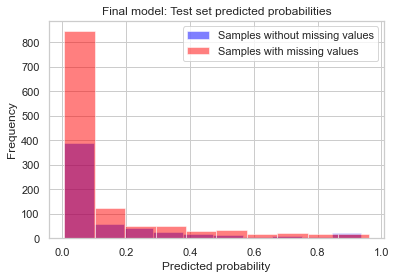

In [15]:
# check whether there are any missing features for a row:
any_missing_feats = (pd.isnull(orig_data_features[np.hstack([x[1] for x in FEATURE_GROUPS])]).sum(axis=1)>0).astype(int)
tmp = copy.deepcopy(orig_data_features)
tmp["any_missing"] = any_missing_feats

# merge missingness variable above with the final full feature model's test set predictions
test_preds_all_cols = pd.read_csv("/Users/nbbwang/Downloads/xgb_preds_train_all_cols_2yrprev_within3_singleyear0.csv", index_col=0)
allcols_preds_w_missing = test_preds_all_cols.merge(tmp, on=["projid", "fu_year"])

plt.hist(allcols_preds_w_missing[allcols_preds_w_missing["any_missing"]==0]["predr"], alpha=.5, color="blue")
plt.hist(allcols_preds_w_missing[allcols_preds_w_missing["any_missing"]==1]["predr"], alpha=.5, color="red")
plt.legend(["Samples without missing values", "Samples with missing values"])
plt.title("Final model: Test set predicted probabilities")
plt.xlabel("Predicted probability")
plt.ylabel("Frequency")

# compare predicted probabilities between samples with and without any missingness
stats.ttest_ind(allcols_preds_w_missing[allcols_preds_w_missing["any_missing"]==0]["predr"], allcols_preds_w_missing[allcols_preds_w_missing["any_missing"]==1]["predr"])

#### Showing missingness separately for each group

Columns: Feature,  between group test (significance),  contols (missingness rate & whether its significantly higher than the other group), dementia onset cases (missingness rate & whether its significantly higher than the other group) 

In [16]:
percentages=True

for feat_group_name, feat_group in FEATURE_GROUPS:
    print("\\textbf{%s}\\\\"%feat_group_name)
    for feat in feat_group:
        controls = orig_data_features[orig_data_features["onset_label_time_binary"]==0][feat]
        dementias = orig_data_features[orig_data_features["onset_label_time_binary"]==1][feat]
        
        # COMPARING ROS VS MAP
#         controls = orig_data_features[orig_data_features["study"]=="ROS "][feat]
#         dementias = orig_data_features[orig_data_features["study"]=="MAP "][feat]
        unique_vals = np.unique(np.hstack([controls.dropna().values, dementias.dropna().values]))

        missing_annot = missingness_annots[feat]
        
        control_missing = missingness_annots_control[feat]
        dem_missing = missingness_annots_dementia[feat]
        
        
        if feat in t_test_vars:

            t,p = stats.ttest_ind(controls.dropna().values,dementias.dropna().values)
            p_stars = "***" if p<.001 else "**" if p <.01 else "*" if p < .05 else ""

            print("%s & $t=%.2f^{%s}$  & $%.2f \pm %.2f$ (%s) &  $%.2f \pm %.2f$ (%s)\\\\ "%(var_names[feat],t,p_stars, controls.mean(), controls.std(), control_missing, dementias.mean(), dementias.std(),dem_missing))

        else:

            # create dictionary of counts for observed values of feature
            control_valcounts = {}
            for i,v in enumerate(controls.value_counts().index):
                control_valcounts[v] = controls.value_counts().values[i]
            dem_valcounts = {}
            for i,v in enumerate(dementias.value_counts().index):
                dem_valcounts[v] = dementias.value_counts().values[i]
            
            for v in unique_vals:
                if v not in control_valcounts.keys():
                    control_valcounts[v]=0
                if v not in dem_valcounts.keys():
                    dem_valcounts[v]=0            

            #get union of all values seen (just in case one of the groups has some 0s for some values)
            all_vals = np.union1d(list(dem_valcounts.keys()), list(control_valcounts.keys()))
            
            # generate contingency table (shape: values observed x groups)
            contingency_table = np.array([[control_valcounts[elt], dem_valcounts[elt]] for elt in all_vals])


            chi2_stat, p, dof, ex = stats.chi2_contingency(contingency_table)
            p_stars = "***" if p<.001 else "**" if p <.01 else "*" if p < .05 else ""

            
            
            if percentages:
                if len(all_vals) < 3:
                    controlfrac =control_valcounts[1]/np.sum(list(control_valcounts.values())) * 100
                    demfrac =dem_valcounts[1]/np.sum(list(dem_valcounts.values())) * 100
                    
                    print("%s & $\chi^2=%.2f^{%s}$  & $%.1f\%%$ (%s) &  $%.1f\%%$ (%s) \\\\ "%(feat.replace("_", "\_"), chi2_stat,p_stars,controlfrac, control_missing, demfrac, dem_missing))
                    

                
                else:
                    outcomes_str = "/".join(all_vals.astype(int).astype(str))
                    
                    controlvals = (np.round(contingency_table[:,0]/sum(contingency_table[:,0])*100,1))
                    demvals = (np.round(contingency_table[:,1]/sum(contingency_table[:,1])*100,1))
                    controlvals_str = "/".join(["%s\%%"%x for x in controlvals.astype(str)])
                    demvals_str = "/".join(["%s\%%"%x for x in demvals.astype(str)])
                
                    print("%s ($%s$) & $\chi^2=%.2f^{%s}$  & $%s$ (%s) &  $%s$  (%s) \\\\ "%(feat.replace("_", "\_"),outcomes_str, chi2_stat,p_stars,controlvals_str, control_missing, demvals_str, dem_missing))
            
            
            else:
                outcomes_str = "/".join(all_vals.astype(int).astype(str))
                controlvals_str = "/".join(contingency_table[:,0].astype(int).astype(str))
                demvals_str = "/".join(contingency_table[:,1].astype(int).astype(str))
                
                print("%s ($%s$) & $\chi^2=%.2f^{%s}$  & $%s$ (%s) &  $%s$  (%s) \\\\ "%(feat.replace("_", "\_"),outcomes_str, chi2_stat,p_stars,controlvals_str,control_missing,  demvals_str, dem_missing))


\textbf{Demographics}\\
Age & $t=-29.60^{***}$  & $80.12 \pm 6.77$ (0\%) &  $86.19 \pm 6.37$ (0\%)\\ 
msex & $\chi^2=15.43^{***}$  & $29.5\%$ (0\%) &  $24.0\%$ (0\%) \\ 
Years of education & $t=1.45^{}$  & $16.91 \pm 3.61$ (0.1\%) &  $16.75 \pm 3.56$ (0.2\%)\\ 
race ($1/2/3/6$) & $\chi^2=12.72^{**}$  & $94.0\%/5.5\%/0.3\%/0.2\%$ (0.0\%) &  $94.2\%/4.9\%/0.2\%/0.6\%$  (0.0\%) \\ 
spanish & $\chi^2=0.10^{}$  & $3.1\%$ (0\%) &  $3.3\%$ (0\%) \\ 
apoe\_4count ($0/1/2$) & $\chi^2=54.59^{***}$  & $78.6\%/20.3\%/1.1\%$ (1.5\%) &  $70.3\%/27.0\%/2.8\%$  (1.4\%) \\ 
\textbf{Episodic Memory (EM)}\\
Word list: immediate (1min) & $t=40.10^{***}$  & $20.57 \pm 4.55$ (2.4\%) &  $15.01 \pm 4.08$ (2.3\%)\\ 
Word list: delayed (1min) & $t=45.43^{***}$  & $6.76 \pm 2.16$ (2.4\%) &  $3.69 \pm 2.34$ (2.4\%)\\ 
Word list: recognition (1min) & $t=32.82^{***}$  & $9.85 \pm 0.56$ (2.3\%) &  $9.02 \pm 1.74$ (2.7\%)\\ 
East boston test: delayed (3min) & $t=26.25^{***}$  & $9.89 \pm 1.73$ (0.3\%) &  $8.46 \pm 2.

### COME UP WITH LIST OF ROWS/COLUMNS TO DROP FOR IMPUTATION EXPERIMENTS (JBHI REVISION)

In [19]:
orig_folder ="../DATA/PROCESSED/"

y = 2
within = 3

cur_year_fname = "merged_kept_data_%iyrprev_within%i.csv"%(y,within)
CURRENT_YEAR = pd.read_csv(orig_folder + cur_year_fname)

In [22]:
to_keep_rows = np.arange(len(CURRENT_YEAR))
tm = []
to_drop_cols = []
drop_col_lim = .2

for v in sig_dif_missing_vars:
    missing_frac = 1 - len(non_nan_idxes[v][0])/len(CURRENT_YEAR) 
    if missing_frac > drop_col_lim:
        to_drop_cols.append(v)
    else:
        tm.append(non_nan_idxes[v][0])
        to_keep_rows = np.intersect1d(to_keep_rows, non_nan_idxes[v][0])

# SAVE THESE FOR ADDITIONAL EXPERIMENTS:

# to_drop_col:   columns with significantly different rates of missingness between dementia and control cases AND over 20% missingness
# to_keep_rows:  rows with any missing values for variables with different rates of missingness (excluding the dropped cols above)

CURRENT_YEAR.iloc[to_keep_rows][["projid", "fu_year"]].to_csv("JBHI_REV_IMPUTATION_EXPERIMENTS/to_keep_rows.csv", index=False)
np.savetxt("JBHI_REV_IMPUTATION_EXPERIMENTS/to_drop_cols.txt", to_drop_cols, fmt="%s")